# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Mitchell

Last Name: Layton

Student ID: 912307956

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [42]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from datetime import datetime
import os
import sqlite3

import geopandas as gpd
import osmnx as ox 
import shapely.geometry as geom



dir_list = os.listdir()
try:
    dir_list[dir_list.index('sf_data.sqlite')]
    conn = sqlite3.connect('sf_data.sqlite')
except ValueError:
    print("database file 'sf_data.sqlite' is not in current working directory")


c = conn.cursor()

def table_column_names(unformatted_cols):
    temp =[]
    for i in unformatted_cols:
        i = list(i)
        temp.append(i[0])

    return(temp)

In [43]:
locations = c.execute("SELECT locationid, Address, Latitude, Longitude FROM mobile_food_locations GROUP BY Address")

table_column_names(locations.description)

['locationid', 'Address', 'Latitude', 'Longitude']

In [44]:
permits = c.execute("SELECT * FROM mobile_food_permits")

table_column_names(permits.description)

['permit',
 'Status',
 'Applicant',
 'FacilityType',
 'FoodItems',
 'PriorPermit',
 'Approved',
 'Expiration']

In [45]:
schedule = c.execute("SELECT * FROM mobile_food_schedule")

table_column_names(schedule.description)


['locationid', 'permit', 'DayOfWeek', 'EndHour', 'StartHour']

In [46]:
# TASK: GET LOCATIONS OF of the mobile food vendor(s) that sell at the most locations

# STEP 1: JOIN mobile_food_permit and mobile_food_schedule on "permit" to get type of food vendor and associated locationid
c.execute('''
CREATE TEMPORARY TABLE Permit_Schedule AS SELECT

locationid,
s.permit,
DayOfWeek,
StartHour,
EndHour,
p.Applicant, 
p.FacilityType, 
p.Status

FROM mobile_food_schedule AS s
INNER JOIN mobile_food_permits AS p
    ON p.permit = s.permit 
    
WHERE p.Status LIKE 'APPROVED' 
''')
# Want to join from mobile_food_schedule on mobile_food_permits because schedule has bulk of information
conn.commit()

In [47]:
perm_sched = c.execute("SELECT * FROM Permit_Schedule")
table_column_names(perm_sched.description)

['locationid',
 'permit',
 'DayOfWeek',
 'StartHour',
 'EndHour',
 'Applicant',
 'FacilityType',
 'Status']

In [48]:
perm_sched = c.execute("SELECT * FROM Permit_Schedule")
p_and_s = pd.DataFrame(perm_sched.fetchall(),columns=(table_column_names(perm_sched.description)))
p_and_s.sample(5)

,locationid,permit,DayOfWeek,StartHour,EndHour,Applicant,FacilityType,Status
219,765703,16MFF-0051,Fr,10,11,Park's Catering,Truck,APPROVED
39,762185,16MFF-0027,Fr,10,11,F & C Catering,Truck,APPROVED
262,765710,16MFF-0051,We,7,8,Park's Catering,Truck,APPROVED
442,765540,16MFF-0049,Su,10,21,Got Snacks,Push Cart,APPROVED
353,763604,16MFF-0037,Fr,10,11,D & T Catering,Truck,APPROVED


In [49]:
c.execute('''
CREATE TEMPORARY TABLE Final_Join AS 

SELECT * 
FROM Permit_Schedule 
INNER JOIN mobile_food_locations ON 
Permit_Schedule.locationid = mobile_food_locations.locationid      
''')

conn.commit()

In [50]:
## We will now query Final_Join table to find the different vendors that sell at the most locations

Final_Joined_Data = c.execute('''
SELECT  
    Applicant as Vendor_Name,
    FacilityType,
    COUNT(DISTINCT(LocationDescription)) as Distinct_Locations

FROM Final_Join
GROUP BY  Applicant
ORDER BY Distinct_Locations DESC
''')

df_1 = pd.DataFrame(Final_Joined_Data.fetchall(), columns=(table_column_names(Final_Joined_Data.description)))
df_1.head(10)

,Vendor_Name,FacilityType,Distinct_Locations
0,Park's Catering,Truck,18
1,D & T Catering,Truck,16
2,F & C Catering,Truck,11
3,Munch A Bunch,Truck,10
4,BH & MT LLC,Truck,7
5,Eva's Catering,Truck,6
6,Linda's Catering,Truck,6
7,Golden Catering,Truck,5
8,"Bay Area Mobile Catering, Inc. dba. Taqueria A...",Truck,4
9,DO UC US Mobile Catering,Truck,4


__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

----

My plan is to take a questions or two from the list above, and then create questions on my own for me to answer:

[QUESTION 1] (From suggested list): What are the best times and places to find food trucks?

To answer this we need to consider what it means to be the 'best' time and place. Ultimately, the 'best' time and place to find a food vendor would be to find a vendor that has many stations scattered throughout San Francisco and has the largest difference of StartHour from EndHour. Both of these factors give us options that result in high availability of randomly finding that company's food truck during operational hours.   

In [51]:
# To find best times and places to find food trucks we can find all of available time ranges
# and count the highest occuring time interval

# RECALL dataframe: df_1


df_2 = pd.read_sql('''
SELECT * FROM Permit_Schedule
''', conn)


#Implement some logic and arithmetic for Hours of Operation
end = df_2['EndHour']
start = df_2['StartHour']

temp = []
for i in range(len(df_2)):
    if end[i] - start[i] > 0 :
        temp.append(str(end[i] - start[i])) 
    elif end[i] - start[i] < 0:
        temp.append(str(24 - (start[i] - end[i])))

df_2['Operational_Hours'] = pd.DataFrame(temp)
# Convert back into sqlite file
df_2.reset_index()
df_2.to_sql('Final_Join2', index = False, con=conn, if_exists='replace')


conn.commit()

df_2.sample(5)
# Adds the Operational_Hours column into the dataframe, then converts the dataframe back to sqlite

,locationid,permit,DayOfWeek,StartHour,EndHour,Applicant,FacilityType,Status,Operational_Hours
683,764864,16MFF-0044,Mo,11,14,Senor Sisig,Truck,APPROVED,3
261,765710,16MFF-0051,Tu,0,13,Park's Catering,Truck,APPROVED,13
204,765700,16MFF-0051,Fr,9,10,Park's Catering,Truck,APPROVED,1
253,765710,16MFF-0051,Mo,7,8,Park's Catering,Truck,APPROVED,1
157,765691,16MFF-0051,We,10,11,Park's Catering,Truck,APPROVED,1


In [52]:
best_available = c.execute('''
SELECT *

FROM Final_Join2

''')

best = pd.DataFrame(best_available.fetchall(), columns=table_column_names(best_available.description))
days = ['Mo','Tu','We','Th','Fr','Sa','Su']
best_vendors_daily = {}
for i in days:
    if len(best[best.DayOfWeek == i]) == 0:
        continue
    else:
        best_vendors_daily[i] = str(len(best[best.DayOfWeek == i]))

        
print(best_vendors_daily)


{'Mo': '150', 'Tu': '142', 'We': '145', 'Th': '144', 'Fr': '145', 'Sa': '36', 'Su': '32'}


What we can see from the numbers above, there is almost a uniformly spread number of mobile food vendors between Monday and Friday. Given that the best chance to find any one random mobile food vendor is highest Mondays-Fridays, let us take a look at the information and data within these days. Therefore, I create two separate analysis where I will find the best time intervals and places to eat for each of these sets of days: {Set 1: Sat-Sun}, {Set 2: M-F}

In [53]:
sat_and_sun = pd.read_sql('''
SELECT 
    DayOfWeek,
    StartHour,
    EndHour,
    Operational_Hours,
    Applicant,
    FacilityType
    
FROM Final_join2
WHERE 
    (
    DayOfWeek LIKE '%Sa%' 
    OR
    DayOfWeek LIKE '%Su%'
    )
ORDER BY Operational_Hours DESC
''', conn)

sat = sat_and_sun[(sat_and_sun['Operational_Hours'].astype(int) >= 8) & (sat_and_sun['DayOfWeek'].astype(str) == 'Sa')]
sun = sat_and_sun[(sat_and_sun['Operational_Hours'].astype(int) >= 8) & (sat_and_sun['DayOfWeek'].astype(str) == 'Su')]

sat = sat.sort_values(by = 'Applicant', ascending=True)
sun = sun.sort_values(by = 'Applicant', ascending=True)

def printed(print_statement):
    '''
    Function is irrelevant to analysis, but wanted to format my print statements
    Input: print statement
    Output: formatted print statement
    '''
    l1 = (">> %s <<"%print_statement)
    l2 = len(l1)
    print("-"*l2)
    print(l1)
    print("-"*l2)

printed("Listed below are the mobile food vendors on the weekends that are open for 8 or more hours.")

sat_and_sun = sat_and_sun[(sat_and_sun.Operational_Hours).astype(int) >= 8]
sat_and_sun.sample(10)

-------------------------------------------------------------------------------------------------
>> Listed below are the mobile food vendors on the weekends that are open for 8 or more hours. <<
-------------------------------------------------------------------------------------------------


,DayOfWeek,StartHour,EndHour,Operational_Hours,Applicant,FacilityType
50,Su,7,20,13,La Jefa,Truck
56,Sa,11,22,11,Subs on Hubs,Truck
54,Sa,10,21,11,Got Snacks,Push Cart
51,Su,7,19,12,San Pancho's Tacos,Truck
36,Su,18,12,18,Leo's Hot Dogs,Push Cart
42,Sa,12,2,14,Subs on Hubs,Truck
52,Sa,8,20,12,Tacos Rodriguez,Truck
41,Su,6,21,15,"The New York Frankfurter Co. of CA, Inc. DBA: ...",Push Cart
5,Su,10,18,8,"Off the Grid Services, LLC",Truck
40,Sa,6,21,15,"The New York Frankfurter Co. of CA, Inc. DBA: ...",Push Cart


In [54]:
def time_frames(days, df):
    '''
    Input 1: days of the week in list format with names like DayOfWeek
    Input 2: the dataframe like "sat_and_sun" above
    Returns: appropriate time format in 24 hr with datetime conversion
    '''    
    temp = {}
    for i in days:
        x = df[(df['Operational_Hours'].astype(int) >= 8) & (df['DayOfWeek'].astype(str) == i)]
        best_avg_time = (round(x['StartHour'].mean(),2),round(x['EndHour'].mean(),2))
        f = str(best_avg_time[0]).split('.')
        g = str(best_avg_time[1]).split('.')
        
        if len(f[1]) == 1 and f[1] == '0':
            f2 = f[0] + ':00'
        elif int(f[1]) > 60:
            NEW1 = round((int(f[1])/100)*60)
            f2 = f[0] + ':' + str(NEW1)
        else:
            f2 = f[0] + ':' + f[1]
        if len(g[1]) == 1 and g[1] == '0':
            g2 = g[0] + ':00'
        elif int(g[1]) > 60:
            NEW2 = round((int(g[1])/100)*60)
            g2 = g[0] + ':' + str(NEW2)
        else:
            g2 = g[0] + ':' + g[1]
        new_best = (f2,g2)
        temp[i] = new_best
        
    #--------------------------   
    import operator
    sorted_temp = sorted(temp.items(), key=operator.itemgetter(1))
    #--------------------------   

    def time_formatted(sorted_temp):
        '''
        Input: sorted temp from above inside bigger function
        Returns: formatted AM/PM 12-hour times
        '''
        for day in sorted_temp:
            d = day[0]
            time = day[1]
            start = str(time[0]).strip(' ')
            end = str(time[1]).strip(' ')
            s = datetime.strptime(start, "%H:%M")
            e = datetime.strptime(end, "%H:%M")
            s2 = s.strftime("%I:%M %p")
            e2 = e.strftime("%I:%M %p")
            print(('>> %s: %s - %s')%(d,s2,e2))
            
    
    ret = time_formatted(sorted_temp)
    
    return(ret)

In [55]:
time_frames(['Sa','Su'],sat_and_sun)

>> Sa: 11:00 AM - 04:47 PM
>> Su: 09:39 AM - 05:06 PM


As shown above, the best time interval to find a mobile food vendor during Saturday is between 11:00 AM - 4:47 PM, and Sunday between about 9:40 AM - 5:00 PM. 

During the weekend, one may randomly find the following options below as being the best time and place to eat.

In [56]:
distinct_applicant_weekends = sat_and_sun.drop_duplicates('Applicant').sort_values(by = 'FacilityType')
distinct_applicant_weekends.reset_index().iloc[:,-2:]

,Applicant,FacilityType
0,"The New York Frankfurter Co. of CA, Inc. DBA: ...",Push Cart
1,Got Snacks,Push Cart
2,"Kabob Trolley, LLC",Push Cart
3,Leo's Hot Dogs,Push Cart
4,HALAL SF GYRO,Push Cart
5,Alfaro's Truck,Truck
6,"Bay Area Mobile Catering, Inc. dba. Taqueria A...",Truck
7,"Off the Grid Services, LLC",Truck
8,DO UC US Mobile Catering,Truck
9,Subs on Hubs,Truck


Comparitively, let us look at Monday-Friday.

In [57]:
mon_thru_fri = pd.read_sql('''
SELECT 
    DayOfWeek,
    StartHour,
    EndHour,
    Operational_Hours,
    Applicant,
    FacilityType
    
FROM Final_join2
WHERE 
    (
    DayOfWeek LIKE '%Mo%' 
    OR
    DayOfWeek LIKE '%Tu%'
    OR
    DayOfWeek LIKE '%We%'
    OR
    DayOfWeek LIKE '%Th%'
    OR
    DayOfWeek LIKE '%Fr%'
    )
ORDER BY Operational_Hours DESC
''', conn)

In [58]:
names_of_weekdays = ['Mo','Tu','We','Th','Fr']

print('\n Best Average Time Intervals for Finding Food Vendor, Sorted by StartHour:\n')
time_frames(names_of_weekdays, mon_thru_fri)


 Best Average Time Intervals for Finding Food Vendor, Sorted by StartHour:

>> Mo: 06:53 AM - 01:03 PM
>> We: 06:57 AM - 02:29 PM
>> Tu: 06:58 AM - 02:45 PM
>> Th: 07:28 AM - 02:02 PM
>> Fr: 07:56 AM - 01:58 PM


As shown above, during the weekdays, there is a relatively even spread of the time intervals. Since these are the mean time intervals of StartHour and EndHour, then on average, one can suggest that these time intervals are the most appropriate times to look for a mobile food vendor. 

Further, one may randomly find that the following options below are being the best time and place to eat during the weekdays.

In [59]:
distinct_applicant_weekdays = mon_thru_fri.drop_duplicates('Applicant').sort_values(by = 'FacilityType')
distinct_applicant_weekdays.reset_index().iloc[:,-2:].sample(5)


,Applicant,FacilityType
35,El Gallo Jiro,Truck
11,"San Francisco Street Foods, Inc.",Push Cart
18,Eva's Catering,Truck
45,The Huge Hotdog Concession,Truck
9,"Kabob Trolley, LLC",Push Cart


Let's plot all of the mobile food vendors that are open for more than 8 hours at a time separately for the weekend and weekdays. This gives users options that are reliable and available in order to accomodate for people's busy schedules and responsibilities. 

In [60]:
# RECALL Final_Join Table, with the 3 main tables joined together.
all_joined = pd.read_sql('''
SELECT * FROM Final_Join
''', conn)
temp_sql = pd.read_sql('''
SELECT * FROM Final_Join2
''', conn)

all_joined['Operational_Hours'] = temp_sql['Operational_Hours']
all_joined = all_joined[(all_joined.Longitude != 0) & (all_joined.Latitude != 0)]

all_joined['Operational_Hours'] = temp_sql['Operational_Hours']
all_joined = all_joined[(all_joined.Longitude != 0) & (all_joined.Latitude != 0)]
all_joined = all_joined.loc[:, all_joined.columns != 'locationid:1']


longi_lati = [geom.Point(x) for x in zip(all_joined.Longitude, all_joined.Latitude)]
vendors = gpd.GeoDataFrame(all_joined, geometry = longi_lati)

In [61]:
Sa_Su = vendors[((vendors.DayOfWeek == 'Sa') | (vendors.DayOfWeek == 'Su')) & (vendors['Operational_Hours'].astype(int) >= 8)]
Sa_Su = Sa_Su.drop_duplicates('Address').sort_values(by = 'Operational_Hours').reset_index().drop(columns = 'index')
Sa_Su = Sa_Su.assign(Time_Type = 'Weekends')

Sa_Su.sample(5)

,locationid,permit,DayOfWeek,StartHour,EndHour,Applicant,FacilityType,Status,LocationDescription,Address,Latitude,Longitude,Operational_Hours,geometry,Time_Type
2,765540,16MFF-0049,Sa,10,21,Got Snacks,Push Cart,APPROVED,03RD ST: TERRY A FRANCOIS BLVD to CHANNEL (100...,1020 03RD ST,37.775510,-122.390999,11,POINT (-122.390999306002 37.7755101380495),Weekends
11,934356,17MFF-0067,Sa,18,12,Leo's Hot Dogs,Push Cart,APPROVED,MISSION ST: 19TH ST to 20TH ST (2300 - 2399),2301 MISSION ST,37.760087,-122.418806,18,POINT (-122.418806481101 37.760086931987),Weekends
5,762515,16MFF-0032,Sa,8,20,Tacos Rodriguez,Truck,APPROVED,EVANS AVE: KEITH ST to MENDELL ST (1201 - 1399...,1275 EVANS AVE,37.739111,-122.382465,12,POINT (-122.382464971136 37.739111429745),Weekends
8,793872,16MFF-0096,Sa,12,2,Subs on Hubs,Truck,APPROVED,05TH ST: HARRISON ST \ I-80 W OFF RAMP to PERR...,400 05TH ST,37.778710,-122.401839,14,POINT (-122.40183935033 37.77871039190089),Weekends
14,761930,16MFF-0023,Su,10,18,"Off the Grid Services, LLC",Truck,APPROVED,BERRY ST: 03RD ST to 04TH ST (100 - 199),185 BERRY ST,37.776327,-122.391797,8,POINT (-122.391796821077 37.7763271477899),Weekends


In [62]:
Mo_Fr = vendors[vendors['DayOfWeek'].isin(names_of_weekdays) & (vendors['Operational_Hours'].astype(int) >= 7)]
Mo_Fr = Mo_Fr.drop_duplicates('Address').sort_values(by = 'Operational_Hours').reset_index().drop(columns = 'index')
Mo_Fr = Mo_Fr.assign(Time_Type = 'Weekdays')

Mo_Fr.sample(5)

,locationid,permit,DayOfWeek,StartHour,EndHour,Applicant,FacilityType,Status,LocationDescription,Address,Latitude,Longitude,Operational_Hours,geometry,Time_Type
31,760542,16MFF-0019,Fr,0,22,Linda's Catering,Truck,APPROVED,TOWNSEND ST: LUSK ST to 04TH ST (252 - 299),260 TOWNSEND ST,37.778148,-122.394441,22,POINT (-122.394440688559 37.7781481274607),Weekdays
12,936624,17MFF-0125,Fr,11,0,BH & MT LLC,Truck,APPROVED,23RD ST: END to ILLINOIS ST (100 - 699),401 23RD ST,37.755031,-122.384531,13,POINT (-122.384530734223 37.7550307267667),Weekdays
48,762514,16MFF-0032,Fr,8,17,Tacos Rodriguez,Truck,APPROVED,OAKDALE AVE: INDUSTRIAL ST \ SELBY ST to TOLAN...,2198 OAKDALE AVE,37.740995,-122.401172,9,POINT (-122.401172335386 37.7409947350024),Weekdays
25,793874,16MFF-0096,Fr,12,2,Subs on Hubs,Truck,APPROVED,08TH ST: FOLSOM ST to RINGOLD ST (300 - 341),333 08TH ST,37.774975,-122.409386,14,POINT (-122.409385823194 37.7749754998217),Weekdays
19,765206,16MFF-0047,Fr,11,0,Golden Catering,Truck,APPROVED,CRESCENT AVE: ANDERSON ST to ELLSWORTH ST (600...,601 CRESCENT AVE,37.735005,-122.415417,13,POINT (-122.415417409745 37.7350052991284),Weekdays


Below is the map of San Francisco for mobile food vendors on the weekend that are open for 8 or more hours.

In [63]:
#Function for plotting maps based on column's only
def map_plot(df, edges_proj, col, cmap):
    '''
    Input: dataframe with GEO lat/lon POINTS, edges_proj (seen from nick's notes), and column of which to plot by
    Returns: Color Map of SF based on criterion with a legend of the column criteria
    '''
    if 'Latitude' in df.columns:
        df_lon_lat = [geom.Point(x) for x in zip(df.Longitude, df.Latitude)]
        geo_df = gpd.GeoDataFrame(df, geometry = df_lon_lat)
    elif 'Lat' in df.columns:
        df_lon_lat = [geom.Point(x) for x in zip(df.Lon, df.Lat)]
        geo_df = gpd.GeoDataFrame(df, geometry = df_lon_lat)

    # Projection string from http://geopandas.org/projections.html
    geo_df.crs = "+init=epsg:4326"
    geo_df_Proj = geo_df.to_crs(utm_crs)
    

    ax = edges_proj.plot(color = 'gray', linewidth = .575, figsize = (16,16))
    ax.set_facecolor('black')

    geo_df_Proj.plot(ax = ax, column = col, cmap = cmap, alpha = 0.5, legend=True)

In [64]:
# MAP FOR WEEKEND Operational_Hours >= 8
sf_streets = ox.graph_from_place("SF, California", network_type = "drive")
nodes, edges = ox.graph_to_gdfs(sf_streets)


# From Nick Discussion Sheet about projections:
# Projection string from http://geopandas.org/projections.html
utm_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
edges_proj = edges.to_crs(utm_crs)


week = pd.DataFrame(pd.concat([Mo_Fr, Sa_Su], axis = 0))
comb = gpd.GeoDataFrame(week)

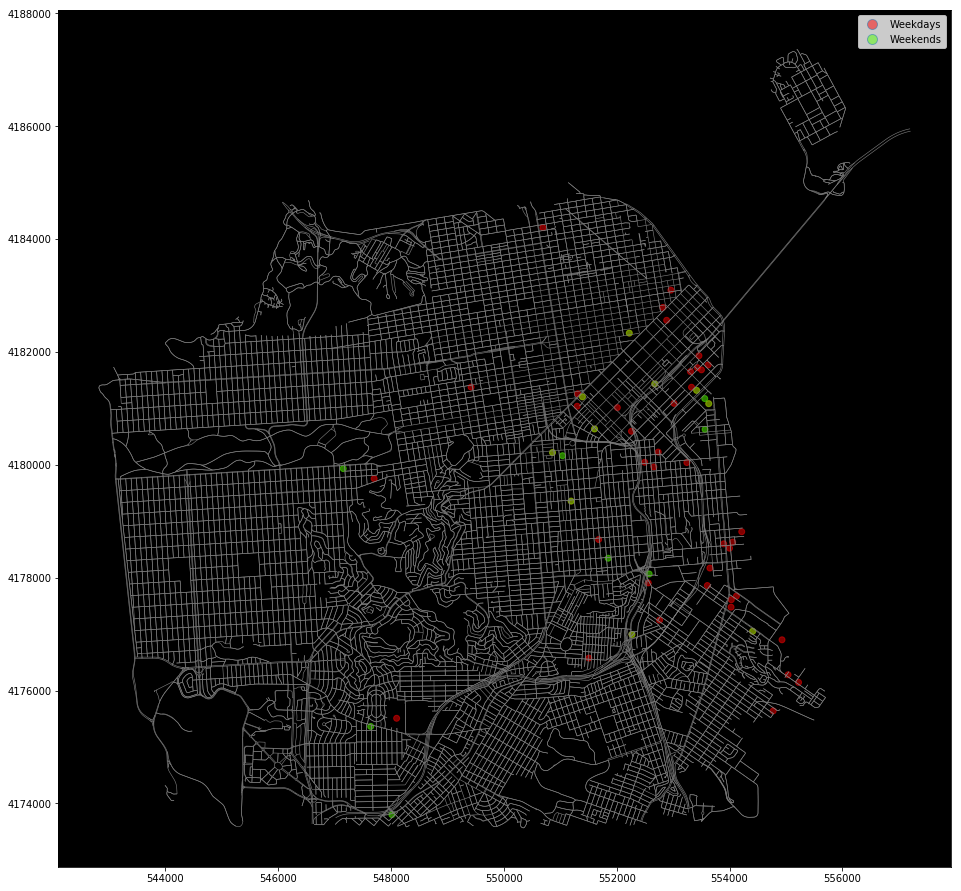

In [65]:
map_plot(comb, edges_proj, col = 'Time_Type', cmap = 'prism')

From the plot of San Francisco above, we can see that green dots are mobile food vendor locations during the weekends Saturday-Sunday, where the red dots are mobile food vendor locations during the weekdays Monday-Friday. The stars that are not green or blue, but are darker blue/green stars are mobile food vendor locations that have vendors that are open for more than 8 hours on both the weekdays and the weekends. 

Visually, we can observe that there a difference between the amount of food vendors during the weekdays and the weekend, where there are more options available during the weekdays. Further, the main spread of the mobile food vendors during the weekdays are centered within the upper middle right corner of the mission district close to the major freeway and eastern piers. Whereas, the weekend mobile food vendors have a larger variance of locations and with less points. This makes sense because they are most likely appealing to tourists and travelers who seek more precise locations (note the most left and central green poimt near golden gate park). It'd be cool to check the red points against business location data to see if these weekday locations are directly associated with the number of businesses and jobs in the area.

--------------------------------------------------------------------------------------------------------------------------------

[QUESTION 2] (From suggested list): Are noise complaints and mobile food vendors related?



In [66]:
noise = pd.read_sql('''
SELECT * FROM Noise 
WHERE 
    (
    Type NOT LIKE '%construction_private_property%' AND
    Type NOT LIKE '%garbage_recycling_collection%' AND
    Type NOT LIKE '%construction_public%' AND
    Type NOT LIKE '%sirens%'
    ) 
    AND
    Lat NOT LIKE '%NaN%'

''', conn)


clean_address = []
ad = noise['Address']
for i in ad:
    if i.find(',') == -1:
        i = 'NaN'
    else:
        i = i.split(',')[0]
    clean_address.append(i)
    
    
noise['Clean_Address'] = pd.DataFrame(clean_address)
noise = noise[noise['Clean_Address'] != 'NaN'].loc[:,noise.columns != 'Address']

noise.to_sql('cleaned_noise', index = False, con=conn, if_exists='replace')
conn.commit()


together = vendors.drop_duplicates('LocationDescription')
together_geo = together.sort_values(by = 'Address').reset_index().drop(columns = 'index')

together = together.reset_index().drop(columns = 'index').loc[:,together.columns != 'geometry']
together.to_sql('distinct_vendor_locations', index = False, con=conn, if_exists='replace')
conn.commit()
print("\n> Distinct vendor locations <")
together.sample(5)


> Distinct vendor locations <


,locationid,permit,DayOfWeek,StartHour,EndHour,Applicant,FacilityType,Status,LocationDescription,Address,Latitude,Longitude,Operational_Hours
21,765691,16MFF-0051,Fr,7,8,Park's Catering,Truck,APPROVED,BURKE AVE: END to 03RD ST (1500 - 1599),1570 BURKE AVE,37.744752,-122.385679,1
69,760540,16MFF-0019,Fr,10,0,Linda's Catering,Truck,APPROVED,02ND ST: BRYANT ST to TABER PL (500 - 518),501 02ND ST,37.783171,-122.392901,14
26,765697,16MFF-0051,Fr,8,9,Park's Catering,Truck,APPROVED,RANKIN ST: DAVIDSON AVE to EVANS AVE (200 - 299),220 RANKIN ST,37.746470,-122.391515,1
54,765205,16MFF-0047,Fr,10,11,Golden Catering,Truck,APPROVED,JAMESTOWN AVE: GRIFFITH ST to CORONADO ST (800...,835 JAMESTOWN AVE,37.717174,-122.392222,1
31,765705,16MFF-0051,Fr,10,11,Park's Catering,Truck,APPROVED,PHELPS ST: FAIRFAX AVE to GALVEZ AVE (500 - 599),525 PHELPS ST,37.741761,-122.389098,1


In [67]:
pd.read_sql('''
sELECT * FROM cleaned_noise
''', conn).sample(5)

,CaseID,Type,Neighborhood,Datetime,Lat,Lon,Clean_Address
1829,5179107,other_excessive_noise,Lower Haight,2015-10-10 23:41:48,37.774317,-122.427131,477 OAK ST
1326,6737804,mechanical_equipment,Union Street,2017-01-17 09:40:48,37.798256,-122.435902,3115 FILLMORE ST
1101,5857214,amplified_sound_electronics,Russian Hill,2016-05-12 03:49:23,37.797007,-122.416436,77 GLOVER ST
1834,5184042,entertainment,Hayes Valley,2015-10-13 12:00:26,37.776928,-122.424605,203 OCTAVIA ST
1385,6834200,amplified_sound_electronics,Bernal Heights,2017-02-12 14:11:51,37.746350,-122.419189,3165 MISSION ST


In [68]:
pd.read_sql('''
SELECT
    cn.Type,
    
    cn.Clean_Address,
    cn.Neighborhood,
    cn.Datetime,
    cn.Lat,
    cn.Lon,
    dvl.Applicant,
    dvl.FacilityType

FROM cleaned_noise as cn
INNER JOIN distinct_vendor_locations as dvl
ON dvl.Address = cn.Clean_Address

''', conn)




,Type,Clean_Address,Neighborhood,Datetime,Lat,Lon,Applicant,FacilityType
0,traffic,400 PARNASSUS AVE,Parnassus Heights,2016-09-09 13:37:47,37.763475,-122.458333,Munch A Bunch,Truck
1,major_event_venue,1 MARKET ST,Financial District,2015-09-09 14:04:55,37.793836,-122.394783,Halal Cart of San Francisco,Push Cart


[ANSWER]: First I started by creating two tables into the sql file called "cleaned_noise" and "distinct_vendor_locations". The cleaned_noise sql is just the same as "Noise" from the sf_data.sqlite file except with the addresses cleaned up so that I would be able to inner join the with the addresses from the distinct mobile food vendor locations to identify any noise complaints at matching addresses. This gives noise information at addresses associated with the food vendors, which only gave 2 observations. Thus, while these may or may not have associations with those respective food vendors, in general, we can say that noise complaints are not related to mobile food vendors.

----------------

[QUESTION 3] Retrieve and analyze the missing person data in the "crime" table of the database file. What are some key characteristics?

In [69]:
# RESOURCE HELP FROM http://geopandas.org/mapping.html "Making Heat Maps"
import scipy.ndimage as ndimg

def heatmap(d,bins, smoothing, cmap, who):
    
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimg.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.xticks(rotation=30)
    plt.xlabel('Longitude', fontsize = 14)
    plt.ylabel('Latitude', fontsize = 14)
    plt.title('Heat Map of '+ who, fontsize = 24)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.show()

In [70]:
missing = pd.read_sql('''
SELECT * FROM crime
WHERE
    Category LIKE '%MISSING PERSON%' AND 
    Descript NOT LIKE '%FOUND%'

''', conn)

# missing_young = missing_young[missing_young['Descript'] == 'MISSING JUVENILE']
missing_adults = missing.copy()
missing_adults = missing_adults[missing_adults['Descript'] == 'MISSING ADULT']
missing_adults['Datetime'] = pd.to_datetime(missing_adults['Datetime']).dt.year
missing_adults.head()


,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150098492,MISSING PERSON,MISSING ADULT,Sunday,2015,CENTRAL,NONE,GRANT AV / WASHINGTON ST,-122.406479,37.795145
1,150098931,MISSING PERSON,MISSING ADULT,Thursday,2015,CENTRAL,NONE,600 Block of CLAY ST,-122.403995,37.794612
2,150099597,MISSING PERSON,MISSING ADULT,Sunday,2015,SOUTHERN,NONE,0 Block of DORE ST,-122.413046,37.773862
3,150100166,MISSING PERSON,MISSING ADULT,Saturday,2015,BAYVIEW,NONE,800 Block of UNIVERSITY ST,-122.411162,37.719669
4,150100401,MISSING PERSON,MISSING ADULT,Tuesday,2015,NORTHERN,NONE,1100 Block of LARKIN ST,-122.418581,37.788191


Text(0.5,1,'Missing Adults Through Various Districts')

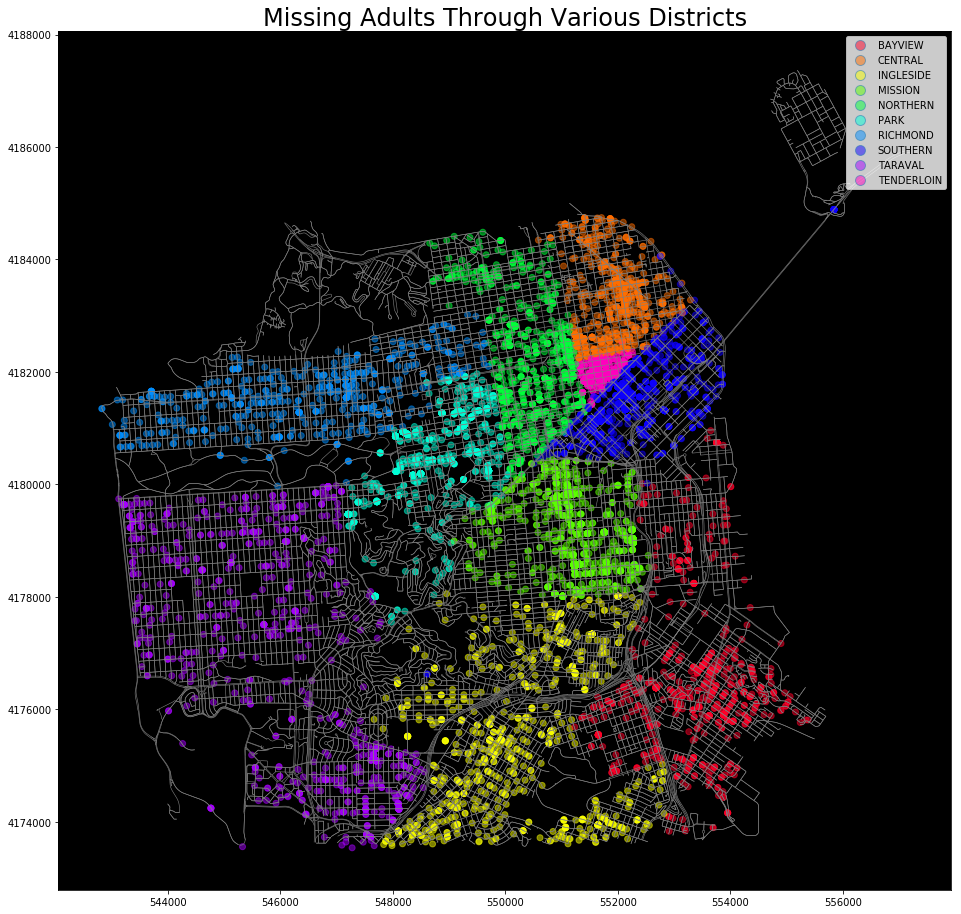

In [71]:
longi_lati_adults = [geom.Point(x) for x in zip(missing_adults.Lon, missing_adults.Lat)]
missing_adults = gpd.GeoDataFrame(missing_adults, geometry = longi_lati_adults)
map_plot(missing_adults, edges_proj, 'PdDistrict', cmap = 'gist_rainbow')
plt.title("Missing Adults Through Various Districts", fontsize = 24)

C:\Users\layto\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


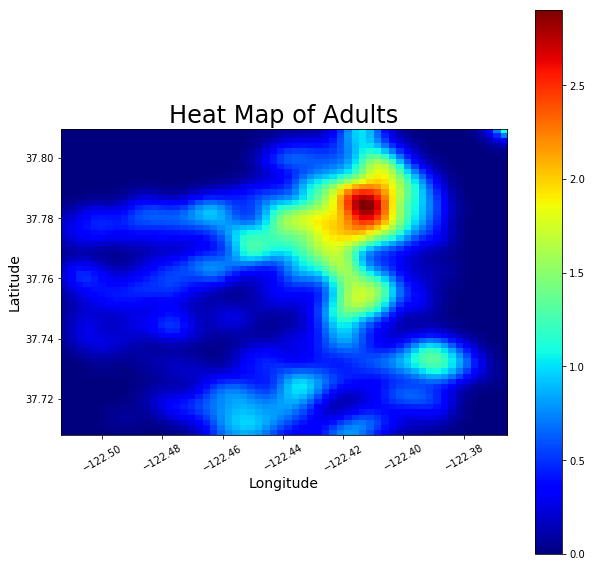

In [76]:
heatmap(missing_adults, bins=60, smoothing=1.9, cmap = 'jet', who ='Adults')

In [73]:
missing_young = missing.copy()
missing_young = missing_young[missing_young['Descript'] == 'MISSING JUVENILE']
missing_young['Datetime'] = pd.to_datetime(missing_young['Datetime']).dt.year
missing_young.head()

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
5,150104754,MISSING PERSON,MISSING JUVENILE,Tuesday,2015,TENDERLOIN,NONE,8TH ST / MARKET ST,-122.414744,37.778719
6,150105683,MISSING PERSON,MISSING JUVENILE,Tuesday,2015,BAYVIEW,NONE,700 Block of JERROLD AV,-122.373456,37.729680
10,150107316,MISSING PERSON,MISSING JUVENILE,Monday,2015,BAYVIEW,NONE,3200 Block of INGALLS ST,-122.393325,37.718826
14,150109340,MISSING PERSON,MISSING JUVENILE,Tuesday,2015,MISSION,NONE,3500 Block of 18TH ST,-122.423373,37.761537
15,150110278,MISSING PERSON,MISSING JUVENILE,Thursday,2015,MISSION,NONE,900 Block of POTRERO AV,-122.406605,37.757158


Text(0.5,1,'Missing Young People Through Various Districts')

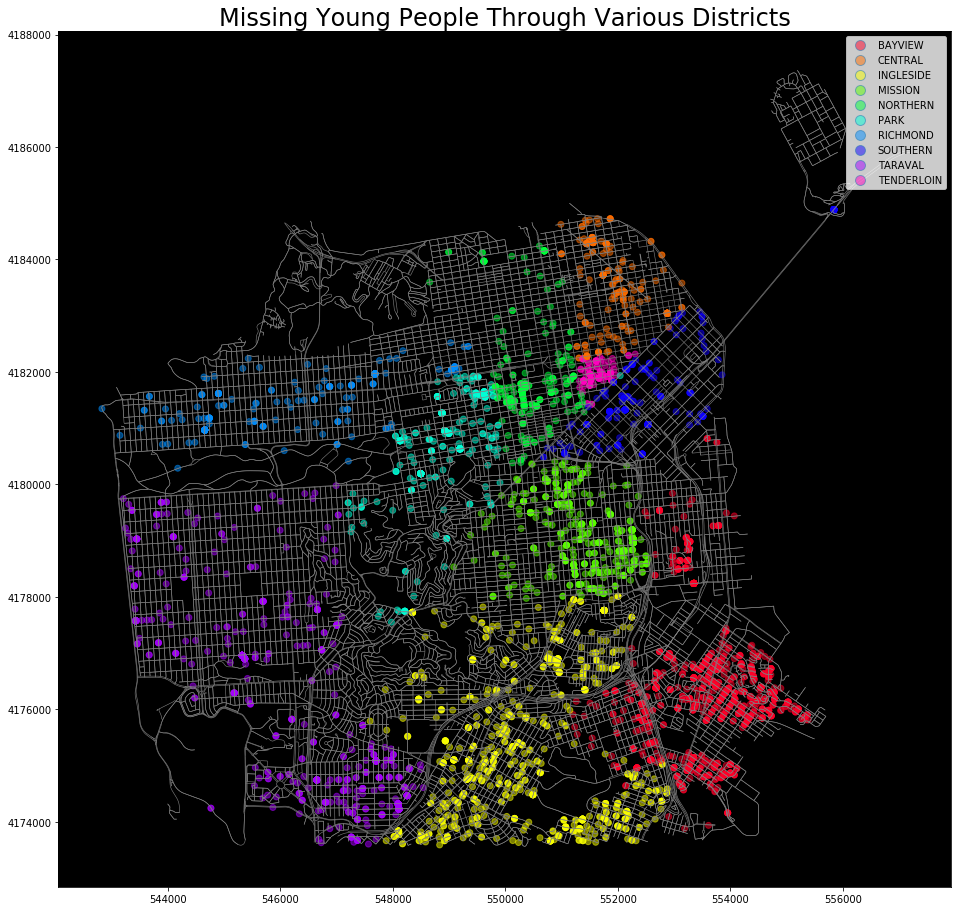

In [74]:
map_plot(missing_young, edges_proj, 'PdDistrict', cmap = 'gist_rainbow')
plt.title("Missing Young People Through Various Districts", fontsize = 24)

C:\Users\layto\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


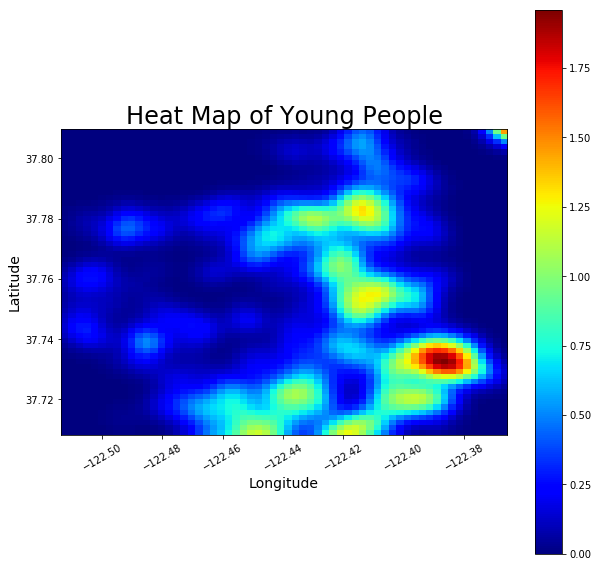

In [75]:
longi_lati_young = [geom.Point(x) for x in zip(missing_young.Lon, missing_young.Lat)]
missing_young = gpd.GeoDataFrame(missing_young, geometry = longi_lati_young)
heatmap(missing_young, bins=60, smoothing=1.9, cmap = 'jet', who ='Young People')

From the heat maps of missing adults and juveniles that were missing and not found, we can see clear difference between the density clusters in distinctly differenct locations. While the adults were mostly lost in the NorthEast corner of the penninsula, the young had more randomly spread out clusters of heat map with the hottest parts missing young occuring in the lower right hand corner of the penninsula. This could be triggered by the Tenderloin district, where there is a lot of drugs, violence, and crime among adults.

In [77]:
adults_per_year = pd.DataFrame(missing_adults.groupby('Datetime').count().iloc[:,0].rename('Adults_Missing'))
adults_per_year = adults_per_year.reset_index()
adults_per_year.columns = ['Year','Adults_Missing']

In [78]:
young_per_year = pd.DataFrame(missing_young.groupby('Datetime').count().iloc[:,0].rename('Young_Missing'))
young_per_year = young_per_year.reset_index()
young_per_year.columns = ['Year','Young_Missing']

In [79]:
both_missing = pd.concat([adults_per_year, young_per_year], axis = 1).iloc[:,[0,1,3]]
both_missing['Adult_to_Young_Ratio'] = both_missing['Adults_Missing']/both_missing['Young_Missing']
both_missing.sort_values(by = 'Year', ascending=False).iloc[1:,:].reset_index().drop(columns = 'index')

#Take out year 2017 because did not have complete data, only had 258 total observations compared to 2016 over 2000.

,Year,Adults_Missing,Young_Missing,Adult_to_Young_Ratio
0,2016,1550,793,1.954603
1,2015,1422,973,1.461459
2,2014,1423,946,1.504228
3,2013,1401,840,1.667857
4,2012,1246,1002,1.243513
5,2011,1336,1289,1.036462
6,2010,1412,1305,1.081992


From the numbers above, the Adult_to_Young_Ratio increased over a 6-year span. By 2016, for every young person that went missing, there were basically 2 adults that went missing. This brings both good new and bad. For one, we see a declining trend in the total number of young people missing per year which means parents are providing their young children, kids, and teenages with more options of saftey especially with mobile phones being put in the hand of every kid nowadays. What's troubling is the opposite relationship to the young, where adults missing per year is increasing. There could be many varirable factors that play into account but it could be increased violence, drugs, etc.

-------------

[QUESTION 4]: Are adult kidnappings and missing adults related?

In [151]:
def nice_date(df_with_datetime):
    '''
    Input: A pandas or geopandas dataframe with a datetime column in it
    Returns: pandas dataframe of datetime column in format like "2-28-2017"
    '''
    df = df_with_datetime
    date_new = []
    x = list(pd.to_datetime(df['Datetime']).dt.year)
    y = list(pd.to_datetime(df['Datetime']).dt.month)
    z = list(pd.to_datetime(df['Datetime']).dt.day)


    for i in range(len(df['Datetime'])):
        neww = str(y[i]) + '-' +  str(z[i]) + '-' + str(x[i]) 
        date_new.append(neww)


    return(pd.DataFrame(date_new))

In [187]:
kidnap = pd.read_sql('''
SELECT * FROM crime
WHERE
    (
    Category LIKE '%KIDNAPPING%' AND Descript LIKE '%KIDNAPPING, ADULT VICTIM%' AND Resolution LIKE '%NONE%'
    )
''', conn)

kidnap['New_Date'] = nice_date(kidnap)
kidnap = kidnap.loc[:,kidnap.columns != 'Datetime']
kidnap.to_sql('kidnap', index = False, con=conn, if_exists='replace')

missing_adults2 = missing.copy()
missing_adults2 = missing_adults2[missing_adults2['Descript'] == 'MISSING ADULT']
missing_adults2['New_Date'] = nice_date(missing_adults2)
missing_adults2.to_sql('missing_adults', index = False, con=conn, if_exists='replace')
missing_adults2

kid_miss = pd.read_sql('''
SELECT 
    kd.Category as Kindap_Category,
    kd.Descript as Kidnap_Desc,
    kd.New_Date as Datetime_Kidnap,
    kd.PdDistrict as Kidnap_Dist,
    kd.Address as Kidnap_Address,
    kd.Lon as Kid_Lon, kd.Lat as Kid_Lat,
    ma.Category as Missing_Category,
    ma.Descript as Missing_Desc,
    ma.New_Date as Datetime_Missing,
    ma.PdDistrict as Missing_Dist,
    ma.Address as Missing_Addres,
    ma.Lon as Miss_Lon, ma.Lat as Miss_Lat

FROM kidnap as kd
INNER JOIN missing_adults as ma
ON ma.Address = kd.Address 

''', conn)
kid_miss2 = kid_miss.copy()
kid_miss2 = kid_miss2[kid_miss2['Datetime_Missing'].notnull()].reset_index().drop(columns='index')

kid_miss2.to_sql('Kidnap_Missing', index = False, con=conn, if_exists='replace')

In [190]:
pd.read_sql('''
SELECT * FROM Kidnap_Missing
WHERE Datetime_Kidnap LIKE Datetime_Missing
''', conn)

,Kindap_Category,Kidnap_Desc,Datetime_Kidnap,Kidnap_Dist,Kidnap_Address,Kid_Lon,Kid_Lat,Missing_Category,Missing_Desc,Datetime_Missing,Missing_Dist,Missing_Addres,Miss_Lon,Miss_Lat
0,KIDNAPPING,"KIDNAPPING, ADULT VICTIM",1-4-2014,SOUTHERN,200 Block of FOLSOM ST,-122.392348,37.789060,MISSING PERSON,MISSING ADULT,1-4-2014,SOUTHERN,200 Block of FOLSOM ST,-122.392348,37.789060
1,KIDNAPPING,"KIDNAPPING, ADULT VICTIM",9-28-2010,SOUTHERN,800 Block of BRYANT ST,-122.403405,37.775421,MISSING PERSON,MISSING ADULT,9-28-2010,SOUTHERN,800 Block of BRYANT ST,-122.403405,37.775421


From the SQL selection statement above, we found observations from crime data of our joined (by address) Missing Person and Kidnapping data to see if and how many records were instances of both. I wanted to find out if there were missing adults that were also reportings of the same kidnapping case. In my findings I found two instances where each column of the records matched perfectly for the date times and accompanying column data. 

My motivtion for this question was due to the idea that one would not expect there to be many cases where there is both a missing adult case that is also a kidnapping of an adult victim. This may be because we expect kidnappings to occur for younger individuals.

[QUESTION 5]: Analyze the Stolen Vehiles Section of 'crime' table.

In [247]:
auto = pd.read_sql('''
SELECT
    Category,
    Descript,
    COUNT(Descript) as Num_Of_Incident
FROM crime
WHERE
    Category LIKE '%VEHICLE THEFT%'
    AND Resolution LIKE '%NONE%'
GROUP BY Descript
''', conn)

auto_theft_counts = auto.copy()
auto_theft_counts = auto_theft_counts.sort_values(by = 'Num_Of_Incident', ascending = False)
auto_theft_counts

,Category,Descript,Num_Of_Incident
3,VEHICLE THEFT,STOLEN AUTOMOBILE,25874
8,VEHICLE THEFT,STOLEN TRUCK,8401
6,VEHICLE THEFT,STOLEN MOTORCYCLE,3209
2,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,2153
0,VEHICLE THEFT,ATTEMPTED STOLEN VEHICLE,342
5,VEHICLE THEFT,STOLEN MISCELLANEOUS VEHICLE,191
7,VEHICLE THEFT,STOLEN TRAILER,23
1,VEHICLE THEFT,"AUTO, GRAND THEFT OF",22
9,VEHICLE THEFT,"VEHICLE, RENTAL, FAILURE TO RETURN",21
4,VEHICLE THEFT,STOLEN BUS,8


From this table above, we can see that automobiles are the most common form of theft which makes sense beacuse of the sheer volume of regular automobiles. Further, there is not much in this table that comes out as surprising to us. Maybe that 8 buses were stolen over the course of many years just goes to show how hard it is to steal buses. The other aspect we can get out of this if finding proportion of cars stolen and recovered to get a feel for how many people are getting their cars recovered. This does not account for any registered vehicles that have been abandoned or outliers. Also the proportion would account for all stolen vehicles since the "stolen and recovered" description only accounts for vehicles in general. It would seem that a small number of people actually get thei vehicles back after being stolen.

In [400]:
grouped = pd.read_sql('''
SELECT
    Category,
    Descript,
    DayOfWeek,
    COUNT(DayOfWeek) as Incidents_On_Day
FROM crime
WHERE
    Category LIKE '%VEHICLE THEFT%'
    AND Resolution LIKE '%NONE%'
GROUP BY Descript, DayOfWeek
''', conn)

grouped

,Category,Descript,DayOfWeek,Incidents_On_Day
0,VEHICLE THEFT,ATTEMPTED STOLEN VEHICLE,Friday,57
1,VEHICLE THEFT,ATTEMPTED STOLEN VEHICLE,Monday,40
2,VEHICLE THEFT,ATTEMPTED STOLEN VEHICLE,Saturday,47
3,VEHICLE THEFT,ATTEMPTED STOLEN VEHICLE,Sunday,51
4,VEHICLE THEFT,ATTEMPTED STOLEN VEHICLE,Thursday,52
5,VEHICLE THEFT,ATTEMPTED STOLEN VEHICLE,Tuesday,47
6,VEHICLE THEFT,ATTEMPTED STOLEN VEHICLE,Wednesday,48
7,VEHICLE THEFT,"AUTO, GRAND THEFT OF",Friday,2
8,VEHICLE THEFT,"AUTO, GRAND THEFT OF",Monday,1
9,VEHICLE THEFT,"AUTO, GRAND THEFT OF",Saturday,5


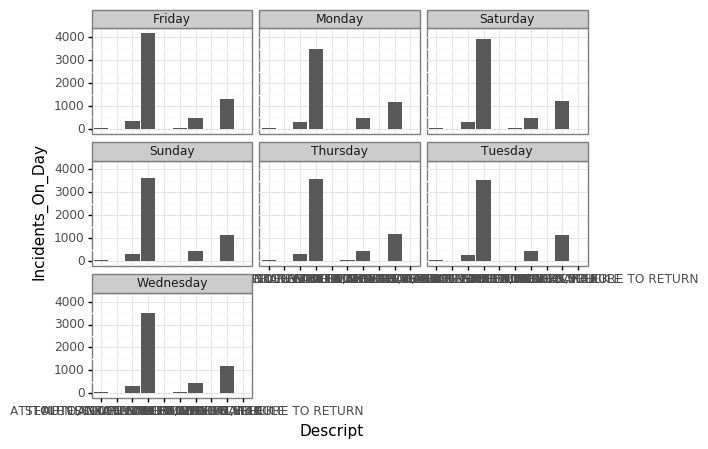

<ggplot: (128373643272)>

In [410]:
import plotnine as gg
from plotnine.data import *


names = grouped['Descript']

p = gg.ggplot(grouped, gg.aes("Descript", "Incidents_On_Day")) + gg.geom_col()
p + gg.theme_bw() + gg.facet_wrap("DayOfWeek")

# (p + gg.scale_x_discrete(limits = names) + gg.scale_y_continuous(limits = [0,27000],breaks = list(range(1,27000,3000)))
#  + gg.theme(axis_text_x = gg.element_text(size = 7.5, angle = 75)) 
#  + gg.labs(title = "Asceding Categorization and Counts of Vehicle Thefts ", x = "Type", y = "Amount_Stolen")
# )

Below was a little for fun. Couldn't get it to work out my way.

In [344]:
print('\nADDING 0 FOR 3 DAYS SINCE ONLY MISSING DATA FOR ALL 7 DAYS FOR ALL VEHICLES FOR USE IN CELL BELOW')
zero_bus_days = pd.DataFrame(data={'Category': ['VEHICLE THEFT','VEHICLE THEFT','VEHICLE THEFT'],'Descript':['STOLEN BUS','STOLEN BUS','STOLEN BUS'], 'DayOfWeek':['Monday','Tuesday','Wednesday'],'Incidents_On_Day':[0,0,0]})
zero_bus_days = zero_bus_days.iloc[:,[0,2,1,3]]
grouped = grouped.append(zero_bus_days)


ADDING 0 FOR 3 DAYS SINCE ONLY MISSING DATA FOR ALL 7 DAYS FOR ALL VEHICLES FOR USE IN CELL BELOW


In [345]:
grouped[grouped['Descript'] == 'STOLEN BUS']

,Category,Descript,DayOfWeek,Incidents_On_Day
28,VEHICLE THEFT,STOLEN BUS,Friday,4
29,VEHICLE THEFT,STOLEN BUS,Saturday,1
30,VEHICLE THEFT,STOLEN BUS,Sunday,1
31,VEHICLE THEFT,STOLEN BUS,Thursday,2
0,VEHICLE THEFT,STOLEN BUS,Monday,0
1,VEHICLE THEFT,STOLEN BUS,Tuesday,0
2,VEHICLE THEFT,STOLEN BUS,Wednesday,0


In [403]:


# !!!! DID NOT WORK THE WAY I WANTED DISCARD THIS CELL. IT WAS MORE FOR FUN



grouped = grouped.sort_values(by = 'Descript', ascending = True)
grouped = grouped.reset_index().drop(columns = 'index')

j = 7
l = 0
seven_days = round(len(grouped)/7)
for i in np.arange(0,len(grouped), seven_days):
    yy = pd.DataFrame()
    t = pd.DataFrame(grouped.loc[list(np.arange(l,j,1)),['Descript','DayOfWeek','Incidents_On_Day']])
    t['DayOfWeek'] = t['DayOfWeek'].astype(str)
    t['DayOfWeek'] = pd.Categorical(t['DayOfWeek'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)
    j = j + 7
    l = l + 7
    del t
